# Analysis of Iris Dataset Results
In this notebook I will look at the results generated by models trained on the iris dataset.

# The Best Configuration of Hyperparameters
My main question: given seven hyperparameters and the settings that I tested, what is the best combination/configuration? I will try answering this question in the context of the Iris dataset (trying to answer that question in the context of all of the six datasets tested on would be very difficult and time consuming!). The seven 'hyperparameters' (albeit some are not strictly hyperparameters, but network architectures/design choices) are: 
- activation_func - the activation function used in the hidden layer
    - The Leaky ReLU and sigmoid activation functions were tested.
- batch_size - the number of samples used in a single training step
    - For the iris dataset batch sizes of 1, 2, 8, 16, 32, and $N$ were tested. For other datasets batch sizes of 1, 2 and $N$ were tested. Note that a batch size of 2 is functionally equivalent to a batch size of $N$ for the 535 dataset since $N=2$ [citation?].
- clf_type - a setting that affects the activation function for the output layer and the loss and scoring functions used
    - For the regression type model the identity activation function was used for the output layer, root mean squared error for the loss function, and the Pearson correlation coefficient for the scoring function.
    - For the classification type model there were two configurations used:
        - For binary classification the sigmoid activation function was used for the output layer, binary cross entropy for the loss function, and accuracy for the scoring function.
        - For multiclass classification (i.e. the iris dataset) the softmax activation function was used for the output layer, categorical cross entropy for the loss function, and accuracy for the scoring function.
- dataset - the dataset that the model is trained on
    - These include all of the datasets in the sample data: 535, encoder, iris, parity-3-bit, parity-4-bit, and xor.
- gaussian_noise - the amount of noise added to the inputs
    - Gaussian noise was generated with zero mean and a variable amount of standard deviation and added to the inputs for each batch. The amounts of standard deviation used were 0.0 (i.e. no noise), 0.01, and 0.1 [citation?].
- learning_rate - the learning constant $\eta$
    - The learning rates of 0.001, 0.01, and 0.1 were tested [citation?].
- momentum - the momentum constant (often seen as $\alpha$)
    - Momentum constants of 0.0 (i.e. no momentum), 0.5, and 0.9 were tested [citation?].
- shuffle_batches - whether or not the dataset, and subsequently the generated (mini) batches, are shuffled at the start of each epoch.

## Methodology
### Weight Initialisation
Weights are initialised using a gaussian random number generator with zero mean and standard deviation of $  \sqrt{\frac{1}{n_{inputs}}}$. The term $\sqrt{\frac{1}{n_{inputs}}}$ is from Xavier initialisation where $n_{inputs}$ is the number of inputs into the unit/layer [1].

### Repeated Trials
Each configuration was trained 40 times. In the case of models trained on the iris dataset, models were trained using eight times repeated five-fold cross-validation - which also gives a total of 40 repetitions for each configuration.

### Control Variables
Each configuration was trained for a maximum of 10,000 epochs.

Two types of early stopping were used across all configurations. 
- Early stopping based on the improvement of either the training loss (most models) or validation loss (models trained on the iris dataset), and if there was no improvement larger than 1e-5 over 100 epochs then training would be stopped early.
- Early stopping based on a score critereon was used. The threshold was set to 0.99 and training would stop when the training score (most models) or the validation score (models trained on the iris dataset) exceeded this value.

A particular network topology was used for each dataset as described by the files in the provided samples files:

| Dataset | # Inputs | # Hidden Units | # Outputs |
|---------|----------|----------------|-----------|
| 535     | 5        | 3              | 5         |
| encoder | 8        | 3              | 8         |
| iris    | 4        | 3              | 3         |
| parity-3-bit | 3        | 3              | 1         |
| parity-4-bit | 4        | 4              | 1         |
| xor     | 2        | 2              | 1         |


## Some Big Numbers
In total there were 4,536 unique configurations of hyperparameters tested 40 times each, totalling in 181,400 individual neural networks that were trained. Due to the different number of batch sizes tested on the the iris dataset, the results have slightly more samples for the models trained on the iris dataset than those trained on other datasets (648 configurations and 25,920 instances more - which is twice as much). This was trained over a total of approximately 800 CPU hours on a 12-core machine (so roughly 2 days and 19 hours in real time).


## Structure of this Document
I will look at each hyperparameter in isolation to see if there are any strong effects, and try to see if there are any combinations of hyperparameters that are particulary performant. As suggested by the title of this document, I focus on the subset of the results for models that were trained on the iris dataset.

## References
[1] Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." In Proceedings of the thirteenth international conference on artificial intelligence and statistics, pp. 249-256. 2010.

## Exploratory Data Analysis
First off, I will have a quick look at what some of the best and worst configurations are.
Configurations are sorted by validation loss and training loss in ascending order, then by validation scores and training scores in descending order. The median values are used instead of the mean values to limit the effect of large outliers that are present in the data. Results for the regression models and the classification models will be looked at separately since they are using quite different metrics which are difficult to directly compare (e.g. RMSE vs. categorical cross entropy, Pearson correlation coefficient vs accuracy).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

In [2]:
df = pd.read_csv('../scripts/results_summary.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4536 entries, ce2406bc88ceda4e2fde96bf96fdd2d5 to 9591fefef4086cbf060bc6afdcee4eba
Columns: 225 entries, activation_func to std_n_epochs
dtypes: bool(1), float64(219), int64(2), object(3)
memory usage: 7.8+ MB


## Score Normalisation
Since the regression models are using Pearson's correlation coefficient for scoring, they range from -1 to 1. However the classification scores range from 0 to 1, making the two difficult to directly compare. As such I will normalise the regression scores into the range 0 to 1.

In [3]:
val_scores_cols = get_val_scores_cols(df)
train_scores_cols = get_train_scores_cols(df)
scores_cols = np.hstack((val_scores_cols, train_scores_cols))

x = df[regression_mask(df)][scores_cols]
x_min, x_max = -1.0, 1.0 # the range of Pearson's correlation coefficient

x = (x - x_min) / (x_max - x_min)
x.describe()

,val_scores_00,val_scores_01,val_scores_02,val_scores_03,val_scores_04,val_scores_05,val_scores_06,val_scores_07,val_scores_08,val_scores_09,...,train_scores_30,train_scores_31,train_scores_32,train_scores_33,train_scores_34,train_scores_35,train_scores_36,train_scores_37,train_scores_38,train_scores_39
count,640.000000,645.000000,645.000000,640.000000,642.000000,643.000000,643.000000,642.000000,640.000000,643.000000,...,1816.000000,1822.000000,1818.000000,1817.000000,1814.000000,1817.000000,1816.000000,1818.000000,1820.000000,1808.000000
mean,0.879092,0.875410,0.876045,0.880273,0.881025,0.876497,0.879895,0.874846,0.876116,0.878513,...,0.787203,0.782600,0.781607,0.784049,0.777483,0.786392,0.784100,0.781584,0.783219,0.787332
std,0.124107,0.129386,0.125915,0.124530,0.120906,0.123394,0.119610,0.127906,0.130114,0.121386,...,0.200958,0.200359,0.201337,0.200873,0.207605,0.196276,0.200675,0.200602,0.202662,0.198761
min,0.341129,0.450070,0.456429,0.415378,0.371529,0.447194,0.434309,0.341147,0.292694,0.427145,...,0.000000,0.179230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
25%,0.847559,0.847339,0.847423,0.847529,0.848244,0.846745,0.845477,0.848407,0.846923,0.847314,...,0.587241,0.561959,0.558304,0.578730,0.538328,0.584320,0.569287,0.564171,0.567057,0.595841
50%,0.906456,0.914787,0.902782,0.907334,0.910376,0.902130,0.903469,0.903549,0.924490,0.902504,...,0.841112,0.828601,0.831767,0.835198,0.827473,0.837489,0.833508,0.828356,0.834006,0.837294
75%,0.968102,0.968806,0.968869,0.970098,0.967769,0.967110,0.969144,0.967702,0.967650,0.968740,...,0.974324,0.973626,0.973644,0.973689,0.973778,0.973296,0.973746,0.973470,0.973370,0.974102
max,0.995054,0.995418,0.995002,0.995048,0.995280,0.996138,0.995044,0.995027,0.995732,0.995345,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.loc[regression_mask(df), scores_cols] = x
df.loc[regression_mask(df), scores_cols].describe()

,val_scores_00,val_scores_01,val_scores_02,val_scores_03,val_scores_04,val_scores_05,val_scores_06,val_scores_07,val_scores_08,val_scores_09,...,train_scores_30,train_scores_31,train_scores_32,train_scores_33,train_scores_34,train_scores_35,train_scores_36,train_scores_37,train_scores_38,train_scores_39
count,640.000000,645.000000,645.000000,640.000000,642.000000,643.000000,643.000000,642.000000,640.000000,643.000000,...,1816.000000,1822.000000,1818.000000,1817.000000,1814.000000,1817.000000,1816.000000,1818.000000,1820.000000,1808.000000
mean,0.879092,0.875410,0.876045,0.880273,0.881025,0.876497,0.879895,0.874846,0.876116,0.878513,...,0.787203,0.782600,0.781607,0.784049,0.777483,0.786392,0.784100,0.781584,0.783219,0.787332
std,0.124107,0.129386,0.125915,0.124530,0.120906,0.123394,0.119610,0.127906,0.130114,0.121386,...,0.200958,0.200359,0.201337,0.200873,0.207605,0.196276,0.200675,0.200602,0.202662,0.198761
min,0.341129,0.450070,0.456429,0.415378,0.371529,0.447194,0.434309,0.341147,0.292694,0.427145,...,0.000000,0.179230,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000
25%,0.847559,0.847339,0.847423,0.847529,0.848244,0.846745,0.845477,0.848407,0.846923,0.847314,...,0.587241,0.561959,0.558304,0.578730,0.538328,0.584320,0.569287,0.564171,0.567057,0.595841
50%,0.906456,0.914787,0.902782,0.907334,0.910376,0.902130,0.903469,0.903549,0.924490,0.902504,...,0.841112,0.828601,0.831767,0.835198,0.827473,0.837489,0.833508,0.828356,0.834006,0.837294
75%,0.968102,0.968806,0.968869,0.970098,0.967769,0.967110,0.969144,0.967702,0.967650,0.968740,...,0.974324,0.973626,0.973644,0.973689,0.973778,0.973296,0.973746,0.973470,0.973370,0.974102
max,0.995054,0.995418,0.995002,0.995048,0.995280,0.996138,0.995044,0.995027,0.995732,0.995345,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Best and Worst Regression
Here we will look at the top 20 regression type models.

In [5]:
df_sorted = df[iris_mask(df)].sort_values(
    by=['median_val_loss', 'median_train_loss', 'median_val_scores', 'median_train_scores'],
    ascending=[True, True, False, False]
)

n = 20

In [6]:
print('Top %d Configurations sorted by Loss and Scores' % n)
df_sorted[variables + summary_stats].head(n)

Top 20 Configurations sorted by Loss and Scores


,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,...,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores,median_n_epochs,mean_n_epochs,std_n_epochs
run_id,,,,,,,,,,,,,,,,,,,,,
52f00a7f10ab78429747b24b8c20785e,LeakyReLU,1,MLPClassifier,iris,0.01,0.100,0.9,True,0.152742,0.190658,...,0.172217,0.085633,0.122786,0.095155,1.000000,0.934234,0.183667,15.0,42.972973,54.344828
92d250e5c4dc5580fb17eb9b04435f9a,LeakyReLU,1,MLPClassifier,iris,0.00,0.010,0.9,False,0.088076,0.093153,...,0.022313,0.090574,0.123526,0.146606,0.966667,0.963333,0.041893,194.5,286.525000,443.654982
33ae3e1d4f968113dde0e73008f1ee12,Sigmoid,1,MLPClassifier,iris,0.01,0.010,0.9,False,0.098160,0.097094,...,0.017692,0.092087,0.105300,0.075044,0.966667,0.970833,0.030370,314.0,354.000000,230.547509
5d5dfe0336fd30868ad4b02e89ec1aa1,LeakyReLU,1,MLPClassifier,iris,0.01,0.010,0.9,False,0.098365,0.104449,...,0.023479,0.093710,0.089095,0.045622,1.000000,0.974167,0.033323,202.0,230.600000,185.910345
784f673b396e4305511885a9d6cd821c,LeakyReLU,1,MLPClassifier,iris,0.00,0.100,0.9,True,0.159841,0.198359,...,0.205342,0.093751,0.201647,0.336082,1.000000,0.905000,0.220921,9.0,48.200000,67.358284
37bb1501df5d29efa625bab8744b9546,Sigmoid,32,MLPClassifier,iris,0.00,0.100,0.5,False,0.064692,0.119269,...,0.022491,0.095385,0.130347,0.101424,0.966667,0.971667,0.031623,2195.0,2933.175000,2749.665685
29806fb340e0d9588fd4fa1ca03e032d,Sigmoid,2,MLPClassifier,iris,0.01,0.100,0.9,False,0.182845,0.203663,...,0.027448,0.095784,0.137100,0.122066,0.983333,0.971667,0.032511,295.5,316.525000,192.777005
ecafd2186fa0c316d86fe8e117d73d35,Sigmoid,1,MLPClassifier,iris,0.00,0.010,0.9,False,0.078259,0.093762,...,0.022778,0.096664,0.112867,0.076188,0.966667,0.965000,0.039187,244.5,857.325000,1418.017167
34f4e089694de759383b44b75b998e91,Sigmoid,1,MLPClassifier,iris,0.00,0.001,0.0,False,0.063970,0.125135,...,0.018237,0.097352,0.147638,0.108751,0.966667,0.964167,0.034909,7642.0,6510.800000,3319.331159


In [7]:
print('Summary of Categorical Columns')
print(df_sorted['activation_func'].head(n).value_counts())
print()
print(df_sorted['shuffle_batches'].head(n).value_counts())

Summary of Categorical Columns
LeakyReLU    11
Sigmoid       9
Name: activation_func, dtype: int64

False    17
True      3
Name: shuffle_batches, dtype: int64


In [8]:
df_sorted[variables + summary_stats].head(n).describe()

,batch_size,gaussian_noise,learning_rate,momentum,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores,median_n_epochs,mean_n_epochs,std_n_epochs
count,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,7.600000,0.00850,0.044200,0.680000,0.136659,0.182890,0.128862,0.956289,0.943708,0.045805,0.098040,0.147195,0.139391,0.974167,0.962212,0.054241,1701.100000,1815.727399,1401.304529
std,11.513836,0.02207,0.046866,0.369352,0.228229,0.236309,0.107704,0.020151,0.033786,0.053050,0.005294,0.048078,0.101187,0.013760,0.016133,0.053604,2058.401875,1824.130784,1152.123906
min,-1.000000,0.00000,0.001000,0.000000,0.055361,0.057976,0.016235,0.895833,0.845833,0.010642,0.085633,0.089095,0.045622,0.966667,0.905000,0.027217,9.000000,42.972973,54.344828
25%,1.000000,0.00000,0.010000,0.500000,0.064596,0.106572,0.083500,0.954167,0.947702,0.020708,0.094977,0.121612,0.091414,0.966667,0.964167,0.031078,234.250000,309.025000,221.104883
50%,1.500000,0.00000,0.010000,0.900000,0.071299,0.123961,0.121947,0.963542,0.954687,0.023987,0.097716,0.137474,0.108991,0.966667,0.966667,0.033323,1300.000000,1257.625000,1325.836326
75%,10.000000,0.01000,0.100000,0.900000,0.098211,0.153215,0.146309,0.966667,0.961426,0.032318,0.102217,0.155905,0.146617,0.970833,0.971042,0.039863,2154.125000,2555.343750,2630.954122
max,32.000000,0.10000,0.100000,0.900000,1.093865,1.174289,0.535422,0.975000,0.978333,0.205342,0.106501,0.316243,0.484755,1.000000,0.974167,0.220921,7642.000000,6510.800000,3319.331159


In [9]:
print('Bottom %d Configurations sorted by Loss and Scores' % n)
df_sorted[variables + summary_stats].tail(n)

Bottom 20 Configurations sorted by Loss and Scores


,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,median_train_loss,mean_train_loss,...,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores,median_n_epochs,mean_n_epochs,std_n_epochs
run_id,,,,,,,,,,,,,,,,,,,,,
348e33802f6c59d817b7e0424a153a12,LeakyReLU,1,MLPClassifier,iris,0.01,0.1,0.9,False,2.435506,2.756139e+00,...,0.000000,13.815511,1.387402e+01,1.850080e-01,0.333333,0.333333,0.000000,101.0,101.000,0.000000
f67eedebde65d686a35d7396469bb7a3,LeakyReLU,1,MLPClassifier,iris,0.00,0.1,0.9,False,2.891787,2.736730e+00,...,0.000000,13.815511,1.338921e+01,1.512874e+00,0.333333,0.333333,0.000000,101.0,101.000,0.000000
2c13de2c87b2649fffed243ca0a1acf3,LeakyReLU,8,MLPClassifier,iris,0.00,0.1,0.9,False,4.144653,3.925088e+00,...,0.138874,13.815511,1.312980e+01,3.027035e+00,0.333333,0.365000,0.139790,101.0,143.525,182.761016
0eb35cb0d0b874779781490fc5032d53,LeakyReLU,8,MLPClassifier,iris,0.10,0.1,0.9,False,4.144653,3.748436e+00,...,0.150234,13.815511,1.212472e+01,4.531790e+00,0.333333,0.416667,0.223288,101.0,108.100,29.245907
daf496521da3c283a4a25dd9e69018da,LeakyReLU,8,MLPClassifier,iris,0.01,0.1,0.9,False,4.144653,3.577636e+00,...,0.191744,13.815511,1.178323e+01,4.900428e+00,0.333333,0.429167,0.231579,101.0,121.175,81.358305
10a6891dc6c24555617679b8bd3d907e,LeakyReLU,16,MLPClassifier,iris,0.00,0.1,0.9,False,6.907755,5.888668e+00,...,0.281968,13.815511,1.021732e+01,6.007097e+00,0.333333,0.497500,0.273980,103.5,238.000,295.858507
088313190f8ae944447fe3369d49adef,LeakyReLU,16,MLPClassifier,iris,0.01,0.1,0.9,False,6.907755,6.164372e+00,...,0.285426,13.815511,1.007580e+01,6.150685e+00,0.333333,0.506667,0.285569,101.0,161.000,130.985221
54ef32bab72eed45a0c302d5919a74cb,LeakyReLU,16,MLPClassifier,iris,0.10,0.1,0.9,False,6.907755,5.965406e+00,...,0.287240,13.815511,9.041604e+00,6.588935e+00,0.333333,0.560000,0.313622,101.0,118.575,49.038388
49fc732443ffdcffae10e2f89be16c4e,LeakyReLU,16,MLPRegressor,iris,0.10,0.1,0.5,False,1.815312,3.515145e+61,...,0.227090,19.547483,2.021865e+116,1.278740e+117,0.044482,0.097528,0.179172,26.0,74.900,139.124884


In [10]:
print('Summary of Categorical Columns')
print(df_sorted['activation_func'].tail(n).value_counts())
print()
print(df_sorted['shuffle_batches'].tail(n).value_counts())

Summary of Categorical Columns
LeakyReLU    20
Name: activation_func, dtype: int64

False    20
Name: shuffle_batches, dtype: int64


In [11]:
df_sorted[variables + summary_stats].tail(n).describe()

,batch_size,gaussian_noise,learning_rate,momentum,median_train_loss,mean_train_loss,std_train_loss,median_train_scores,mean_train_scores,std_train_scores,median_val_loss,mean_val_loss,std_val_loss,median_val_scores,mean_val_scores,std_val_scores,median_n_epochs,mean_n_epochs,std_n_epochs
count,20.000000,20.000000,2.000000e+01,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,20.500000,0.038500,1.000000e-01,0.595000,689.988514,1.673840e+149,1.058629e+150,0.137943,0.278976,0.303960,839.017305,1.002233e+141,5.629515e+141,0.185363,0.327625,0.277328,81.800000,339.896250,631.891403
std,11.564465,0.046484,1.423831e-17,0.385903,2147.607538,6.318666e+149,3.996275e+150,0.203660,0.142753,0.147487,1639.491883,3.587135e+141,1.960390e+142,0.126732,0.114471,0.118087,38.686799,325.895146,770.205848
min,1.000000,0.000000,1.000000e-01,0.000000,1.312590,2.736730e+00,5.650295e-01,-0.191459,0.010684,0.000000,13.815511,9.041604e+00,1.850080e-01,0.018199,0.097528,0.000000,17.500000,74.900000,0.000000
25%,14.000000,0.000000,1.000000e-01,0.375000,3.831437,5.397773e+00,3.066900e+00,-0.053309,0.161894,0.218254,13.815511,1.287853e+01,5.730430e+00,0.089098,0.259001,0.229506,47.875000,120.525000,118.578492
50%,16.000000,0.010000,1.000000e-01,0.900000,6.907755,7.692492e+107,4.865159e+108,0.268501,0.302001,0.312366,25.553245,1.860654e+107,1.176781e+108,0.120639,0.312937,0.323032,101.000000,219.462500,338.030137
75%,32.000000,0.100000,1.000000e-01,0.900000,90.861835,2.891563e+141,1.828785e+142,0.317708,0.368906,0.427471,480.819408,4.377971e+119,2.768308e+120,0.333333,0.387246,0.351062,101.000000,426.043750,827.586500
max,32.000000,0.100000,1.000000e-01,0.900000,9414.774997,2.801456e+150,1.771796e+151,0.333333,0.520117,0.469982,5216.627619,1.595803e+142,8.683633e+142,0.333333,0.560000,0.390785,174.000000,1135.575000,2434.118424


## Extreme Values in Loss Metrics
Some configurations would occasionally have high loss, likely due to the ReLU configuration's loss exploding (this happened sometimes). Visually inspecting the data tells us that the main factor contribruting to this would be a learning rate of 0.1, as that is the only hyperparameter that is consistent amoung the cases where the loss exploded. This is clear with the maximum observed validation loss, where for models using a ReLU activation it is over 100 orders of magnitude larger than the maximum validation loss observed for models using the sigmoid activation - as shown in the table below:


|*Table: Maximum Observed Validation Loss by Model Activation Function*|
|-|

| Activation Function | Maximum Validation Loss |
|---------------------|-------------------------|
| ReLU                | 4.4136e+149             |
| Sigmoid             | 1.3816e+01              |

In [12]:
df[relu_mask(df) & iris_mask(df)][(df[relu_mask(df) & iris_mask(df)].filter(regex='val_loss_\d{2}') > 1e9).any(axis=1)].describe()

,batch_size,gaussian_noise,learning_rate,momentum,train_scores_00,train_scores_01,train_scores_02,train_scores_03,train_scores_04,train_scores_05,...,median_train_loss,median_train_scores,median_val_loss,median_val_scores,median_n_epochs,std_train_loss,std_train_scores,std_val_loss,std_val_scores,std_n_epochs
count,78.000000,78.000000,7.800000e+01,78.000000,73.000000,78.000000,77.000000,73.000000,76.000000,76.000000,...,78.000000,78.000000,78.000000,78.000000,78.000000,7.800000e+01,78.000000,7.800000e+01,78.000000,78.000000
mean,13.089744,0.037949,1.000000e-01,0.455128,0.785351,0.724662,0.766603,0.792780,0.794241,0.765725,...,176.816873,0.559865,215.507053,0.427450,517.102564,2.714456e+149,0.258402,9.334624e+146,0.294306,737.585099
std,11.859771,0.045623,4.190284e-17,0.370905,0.180090,0.203919,0.197300,0.175736,0.168403,0.175175,...,1109.083140,0.310678,893.895359,0.325969,1044.967915,2.038910e+150,0.112239,8.001224e+147,0.087693,861.289596
min,-1.000000,0.000000,1.000000e-01,0.000000,0.359926,0.358731,0.359402,0.358987,0.361686,0.360776,...,0.127533,-0.191459,0.162091,0.018199,3.000000,2.975255e+00,0.026202,8.318090e+10,0.145113,35.681698
25%,2.000000,0.000000,1.000000e-01,0.000000,0.701239,0.520546,0.597474,0.694724,0.710564,0.643090,...,0.275376,0.398734,0.300102,0.088545,16.625000,5.597249e+47,0.176346,5.039438e+67,0.230199,167.670604
50%,8.000000,0.010000,1.000000e-01,0.500000,0.822218,0.742635,0.789288,0.870226,0.823193,0.784711,...,0.373466,0.560199,0.497139,0.418021,64.750000,5.360092e+93,0.237443,5.847691e+103,0.298833,385.783446
75%,16.000000,0.100000,1.000000e-01,0.900000,0.959610,0.937475,0.964380,0.963621,0.960304,0.935984,...,0.816536,0.822295,7.450559,0.740828,441.250000,8.553636e+127,0.341919,2.434088e+130,0.365898,819.822118
max,32.000000,0.100000,1.000000e-01,0.900000,0.980824,0.984769,0.981635,0.981137,0.978371,0.980508,...,9414.774997,0.937257,5216.627619,0.921719,5508.500000,1.771796e+151,0.469982,7.067382e+148,0.470324,3807.582677


In [13]:
df[relu_mask(df) & iris_mask(df)][(df[relu_mask(df) & iris_mask(df)].filter(regex='val_loss_\d{2}') > 1e9).any(axis=1)]

,activation_func,batch_size,clf_type,dataset,gaussian_noise,learning_rate,momentum,shuffle_batches,train_scores_00,train_scores_01,...,median_train_loss,median_train_scores,median_val_loss,median_val_scores,median_n_epochs,std_train_loss,std_train_scores,std_val_loss,std_val_scores,std_n_epochs
run_id,,,,,,,,,,,,,,,,,,,,,
c5eb49fa0f9d4ce25a0c145ed8a5a337,LeakyReLU,1,MLPRegressor,iris,0.00,0.1,0.0,True,0.778305,0.766680,...,0.301519,0.535183,0.468039,0.428070,4.0,2.869354e+01,0.196052,2.707430e+15,0.299261,119.466523
e13df1a75ba0bec88043802b1317049f,LeakyReLU,1,MLPRegressor,iris,0.10,0.1,0.5,False,NaN,0.950535,...,0.131849,0.932560,0.515641,0.338353,56.0,2.975255e+00,0.026202,5.962337e+11,0.229589,67.234542
053ebc3ea2981661224576e41db1932d,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.9,True,0.733133,0.716783,...,0.432518,0.475832,0.682518,0.333394,43.0,1.066820e+94,0.294226,1.848768e+118,0.365786,349.332952
16caae5ffeca67e6c24cfefd39434739,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.9,False,0.736285,0.574887,...,0.536533,0.484187,7.156062,0.033840,3.0,1.509551e+75,0.182029,7.067382e+148,0.160578,154.323984
733892d6c136231a7ee0e7410152de94,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.5,True,0.968610,0.487822,...,0.279484,0.754945,0.289992,0.754480,385.5,8.806020e+75,0.288366,5.056198e+80,0.363116,370.512202
fd04834aaaef126fbd4fe67b405bf529,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.5,False,0.972905,0.778237,...,0.527701,0.553733,3.846257,0.065233,21.0,2.818662e+60,0.193859,4.458328e+120,0.296047,1542.890860
8bc7305e675694eab29cf08a4ed18137,LeakyReLU,8,MLPRegressor,iris,0.00,0.1,0.0,False,0.788798,0.744946,...,0.708070,0.535058,10.063332,0.053993,27.0,5.432923e+44,0.155453,7.958544e+91,0.270759,426.782629
d014d48b63a4a7b5c00dc6da68ee1a47,LeakyReLU,8,MLPRegressor,iris,0.10,0.1,0.9,True,0.875314,0.899633,...,0.436629,0.517274,0.611381,0.346523,34.0,6.143818e+107,0.221391,3.766562e+91,0.304490,351.005838
0385f5695765ce77a8b1a5cebd0d2a72,LeakyReLU,8,MLPRegressor,iris,0.10,0.1,0.9,False,0.823940,0.652211,...,0.411618,0.550803,1.037256,0.042910,3.0,1.565676e+145,0.206314,4.600988e+144,0.162682,145.664417


In [14]:
relu_max_loss = df[relu_mask(df) & iris_mask(df)].filter(regex='val_loss_\d{2}').max().max()
not_relu_max_loss = df[~relu_mask(df) & iris_mask(df)].filter(regex='val_loss_\d{2}').max().max()
print('Max loss with ReLU: %.4e \nMax loss with Sigmoid: %.4e' % (relu_max_loss, not_relu_max_loss))

Max loss with ReLU: 4.4136e+149 
Max loss with Sigmoid: 1.3816e+01


### Finding the Best Range of Loss to View
With some trial and error, the best range of loss values to view without losing too much information seem to be in the interval [0, 2].
Loss will be truncated to this interval from here on out.

(<Figure size 864x576 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e8209710>,
       dtype=object))

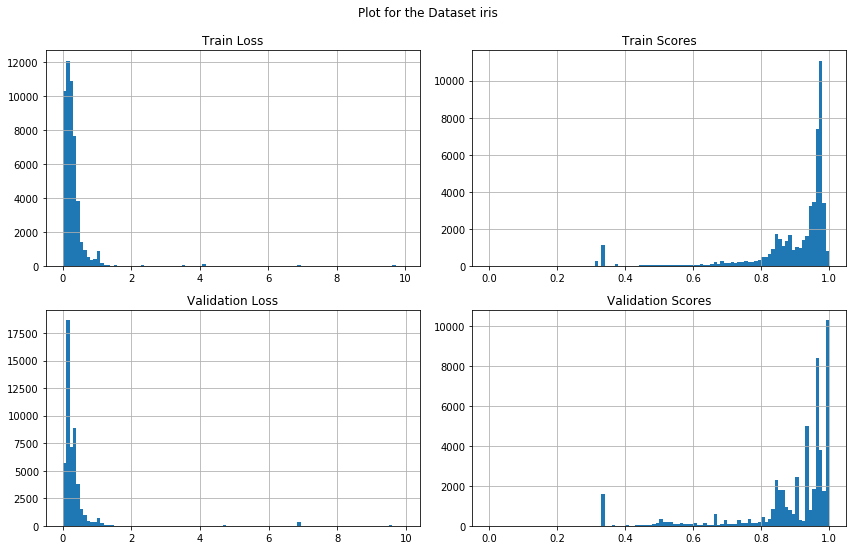

In [15]:
plot(df[iris_mask(df)], thresholds=(10, -1, 10, -1))

(<Figure size 864x576 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e4f7f710>,
       dtype=object))

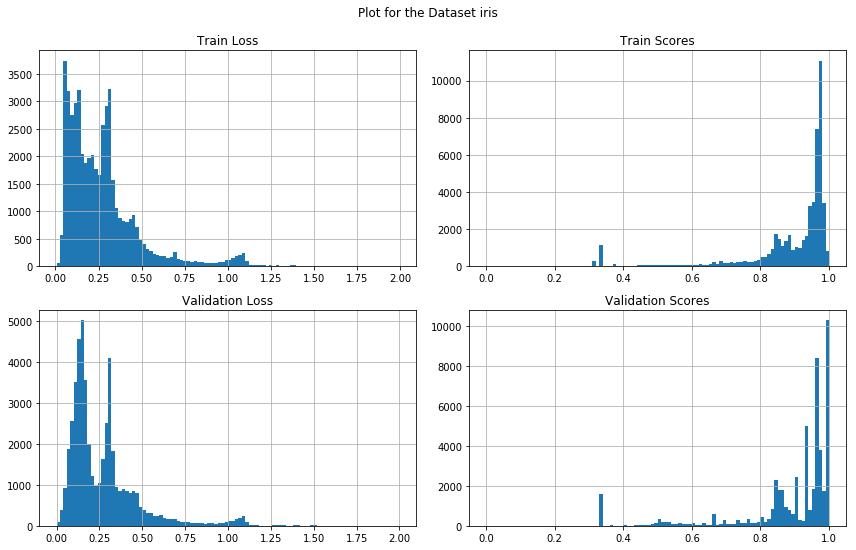

In [16]:
plot(df[iris_mask(df)], thresholds=(2, -1, 2, -1))

# Failure Rate
As observed in the notebook `Exploratory Data Analysis.ipynb`, there were a significant number of configurations that failed to converge. A model is considered to fail to converge if its score got stuck in the middle of its range. These values are 0.0 for regression tasks using Pearson's Correlation Coefficient or 0.5 RMSE loss - with the latter being more reliable; and 0.5 for accuracy in classification tasks.

Comparing the failure rate of all models by dataset, it is shown that the models trained on the Iris dataset are the most successful. Even though the boxplot would suggest that models trained on the encoder dataset are more successful, the small feature space makes me want to favour the models trained on the Iris dataset because I would believe these models to be more representative of artificial neural networks *in the wild* so to speak. 

Comparing the failure rate within the set of models trained on the Iris dataset reaffirms (although perhaps does not prove) the idea that the combination of the Leaky ReLU activation and a learning rate of 0.1 is correlated with poor model performance.

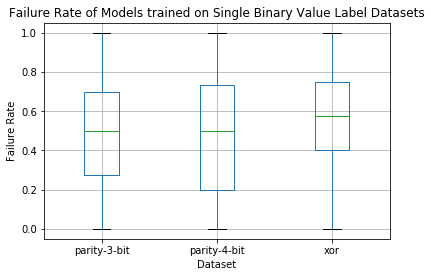

In [17]:
single_binary_output = df['dataset'].isin(['parity-3-bit', 'parity-4-bit', 'xor'])

ax = df[single_binary_output].boxplot(column='fail_rate', by='dataset')
ax.set_ylabel('Failure Rate')
ax.set_xlabel('Dataset')
ax.set_title('Failure Rate of Models trained on Single Binary Value Label Datasets')
plt.suptitle('');  # get rid of the generic title pandas gives us.

The iris data set does not suffer from this issue.

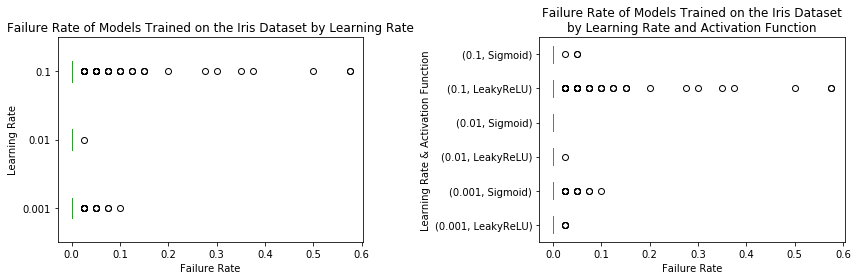

In [18]:
fig, axes = plt.subplots(1, 2, squeeze=True, figsize=(12, 4))

ax = df[iris_mask(df)].boxplot(column='fail_rate', by='learning_rate', 
                                  vert=False, grid=False, ax=axes[0])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Learning Rate')
ax.set_title('Failure Rate of Models Trained on the Iris Dataset by Learning Rate')

ax = df[iris_mask(df)].boxplot(column='fail_rate', by=['learning_rate', 'activation_func'], 
                                  vert=False, grid=False, ax=axes[1])
ax.set_xlabel('Failure Rate')
ax.set_ylabel('Learning Rate & Activation Function')
ax.set_title('Failure Rate of Models Trained on the Iris Dataset\nby Learning Rate and Activation Function')
plt.suptitle('');  # get rid of the generic title pandas gives us.
plt.tight_layout()

## Adding Noise to Inputs

In [19]:
def get_noise_masks_labels():
    noise_levels = list(sorted(df['gaussian_noise'].unique()))
    
    masks = (df['gaussian_noise'] == z for z in noise_levels)
    labels = ('gaussian_noise=%0.2f' % z for z in noise_levels)
    
    return masks, labels

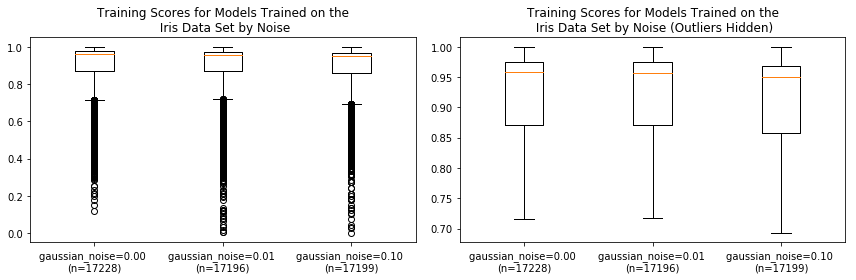

In [20]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_noise_masks_labels(), 
                  'train_scores', 
                  'Training Scores for Models Trained on the\n Iris Data Set by Noise')

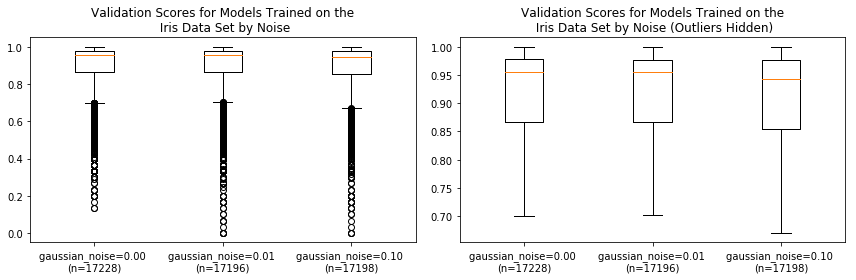

In [21]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_noise_masks_labels(), 
                  'val_scores', 
                  'Validation Scores for Models Trained on the\n Iris Data Set by Noise')

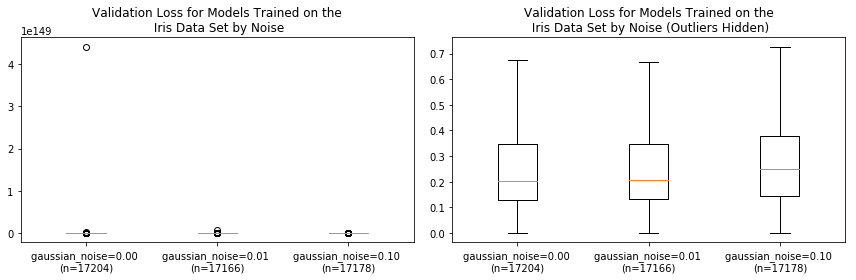

In [22]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_noise_masks_labels(), 
                  'val_loss', 
                  'Validation Loss for Models Trained on the\n Iris Data Set by Noise')

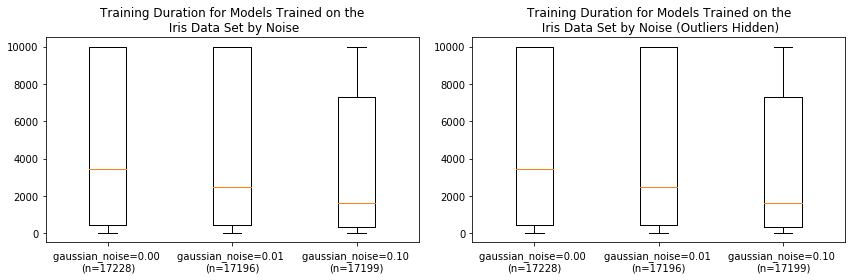

In [23]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_noise_masks_labels(), 
                  'n_epochs', 
                  'Training Duration for Models Trained on the\n Iris Data Set by Noise')

## Appropriate Batch Size
What is the best batch size? The batch sizes tested were 1 (equivalent to standard SGD), 2, 4, 8, 16, 32, and $N$ (i.e. batch SGD).

(<Figure size 1296x864 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e43b3748>,
       dtype=object))

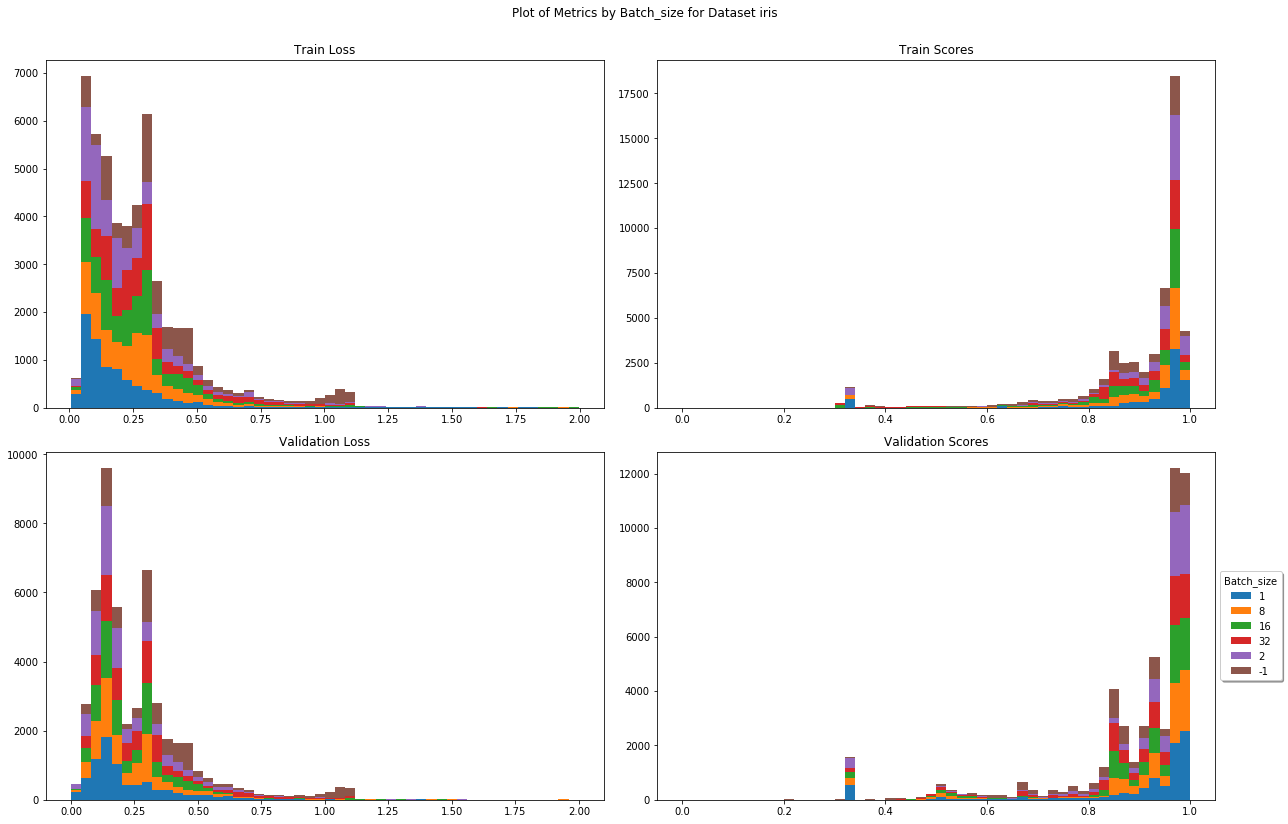

In [24]:
plot_hue(df[iris_mask(df)], hue='batch_size', stacked=True, thresholds=(2, -1, 2, -1))

In [25]:
def get_batch_masks_labels():
    batch_sizes = list(sorted(df['batch_size'].unique()))
    batch_sizes = np.hstack([batch_sizes[1:], batch_sizes[0]]) # put negative one at the end since it represent a batch size of N

    batch_size_masks = (df['batch_size'] == n for n in batch_sizes)
    batch_size_labels = []

    for n in batch_sizes:
        if n > 0:
            batch_size_labels.append('batch_size=%d' % n)
        else:
            batch_size_labels.append('batch_size=N')
            
    return batch_size_masks, batch_size_labels


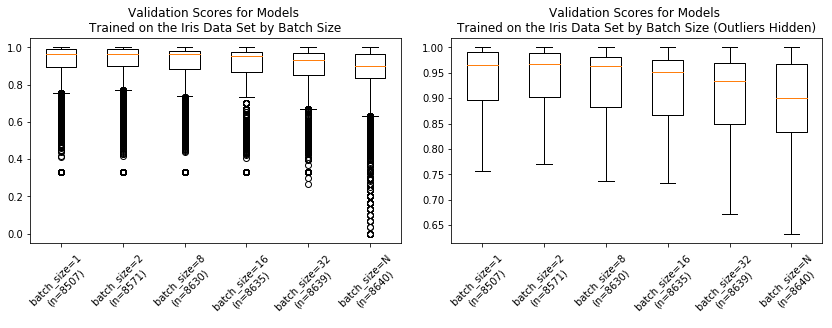

In [26]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_batch_masks_labels(), 
                  'val_scores', 
                  'Validation Scores for Models \nTrained on the Iris Data Set by Batch Size')

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

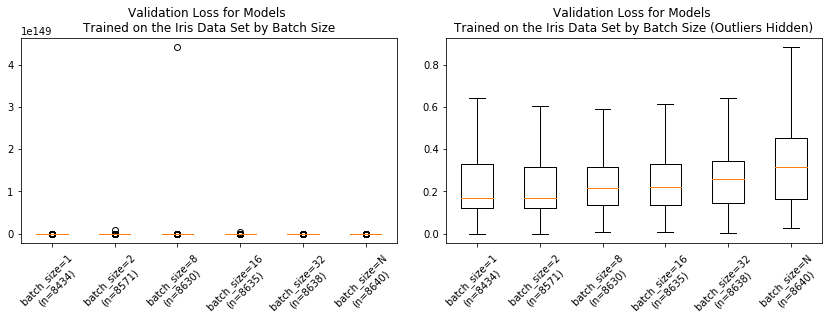

In [27]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_batch_masks_labels(), 
                  'val_loss', 
                  'Validation Loss for Models \nTrained on the Iris Data Set by Batch Size')

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

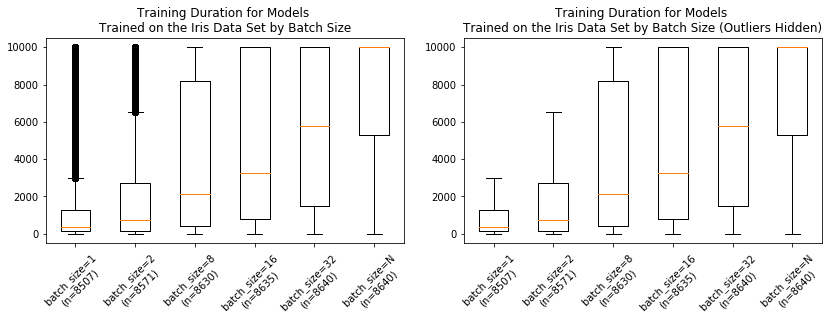

In [28]:
fig, axes = make_n_way_boxplot(df, iris_mask(df), 
                  *get_batch_masks_labels(), 
                  'n_epochs', 
                  'Training Duration for Models \nTrained on the Iris Data Set by Batch Size')

for ax in axes:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

## Shuffle Batches

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d38b30f0>,
       dtype=object))

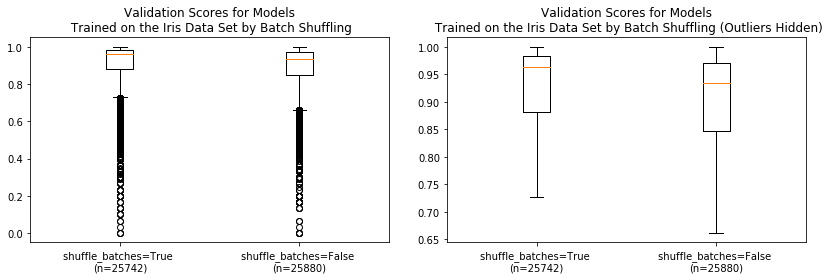

In [29]:
make_boxplot(df, iris_mask(df), get_shuffle_batches(df), 
             'shuffle_batches=True',  'shuffle_batches=False', 'val_scores', 
             'Validation Scores for Models\n Trained on the Iris Data Set by Batch Shuffling')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d37f0c50>,
       dtype=object))

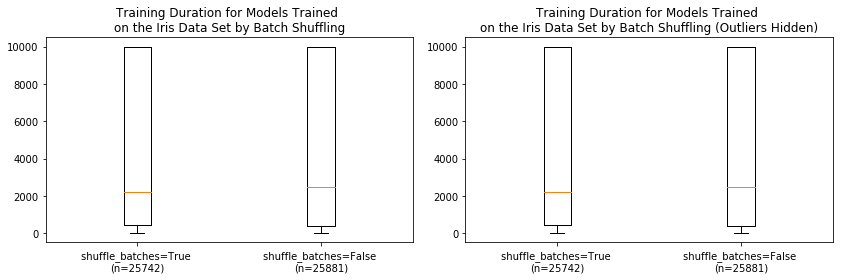

In [30]:
make_boxplot(df, iris_mask(df), get_shuffle_batches(df), 
             'shuffle_batches=True',  'shuffle_batches=False', 'n_epochs', 
             'Training Duration for Models Trained \non the Iris Data Set by Batch Shuffling')

## Learning Task Representation

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d37c69e8>,
       dtype=object))

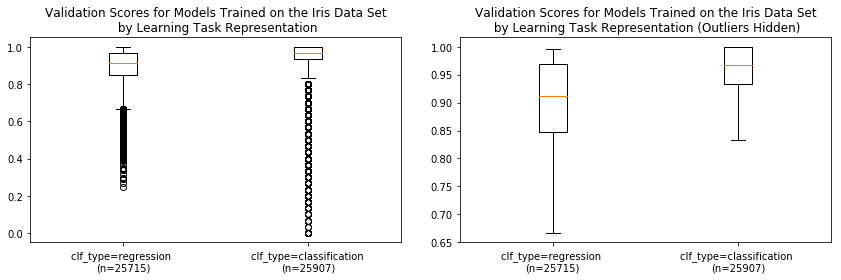

In [31]:
make_boxplot(df, iris_mask(df), regression_mask(df), 
             'clf_type=regression',  'clf_type=classification', 
             'val_scores', 
             'Validation Scores for Models Trained on the Iris Data Set\n by Learning Task Representation')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2f98cc0>,
       dtype=object))

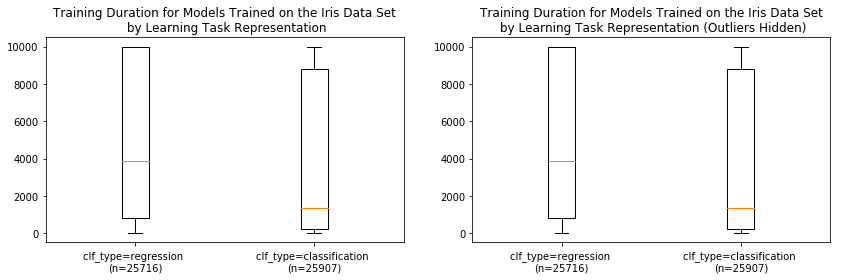

In [32]:
make_boxplot(df, iris_mask(df), regression_mask(df), 
             'clf_type=regression',  'clf_type=classification', 'n_epochs', 
             'Training Duration for Models Trained on the Iris Data Set\n by Learning Task Representation')

# ReLU or Sigmoid?
The activation functions used in the hidden layer that I explored were the leaky ReLU ($\alpha=0.1$) and the sigmoid activation functions. The ReLU family of activation functions have some advantages over the sigmoid activation function, particularly in deep neural networks [1]. However, it would seem that the unbounded nature of the ReLU activation function ends up causing some of the models to fail catastrophically, resulting in their  loss skyrocketing towards infinity.

[1] Glorot, Xavier, Antoine Bordes, and Yoshua Bengio. "Deep sparse rectifier neural networks." In Proceedings of the fourteenth international conference on artificial intelligence and statistics, pp. 315-323. 2011.

(<Figure size 1296x864 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2f7bdd8>,
       dtype=object))

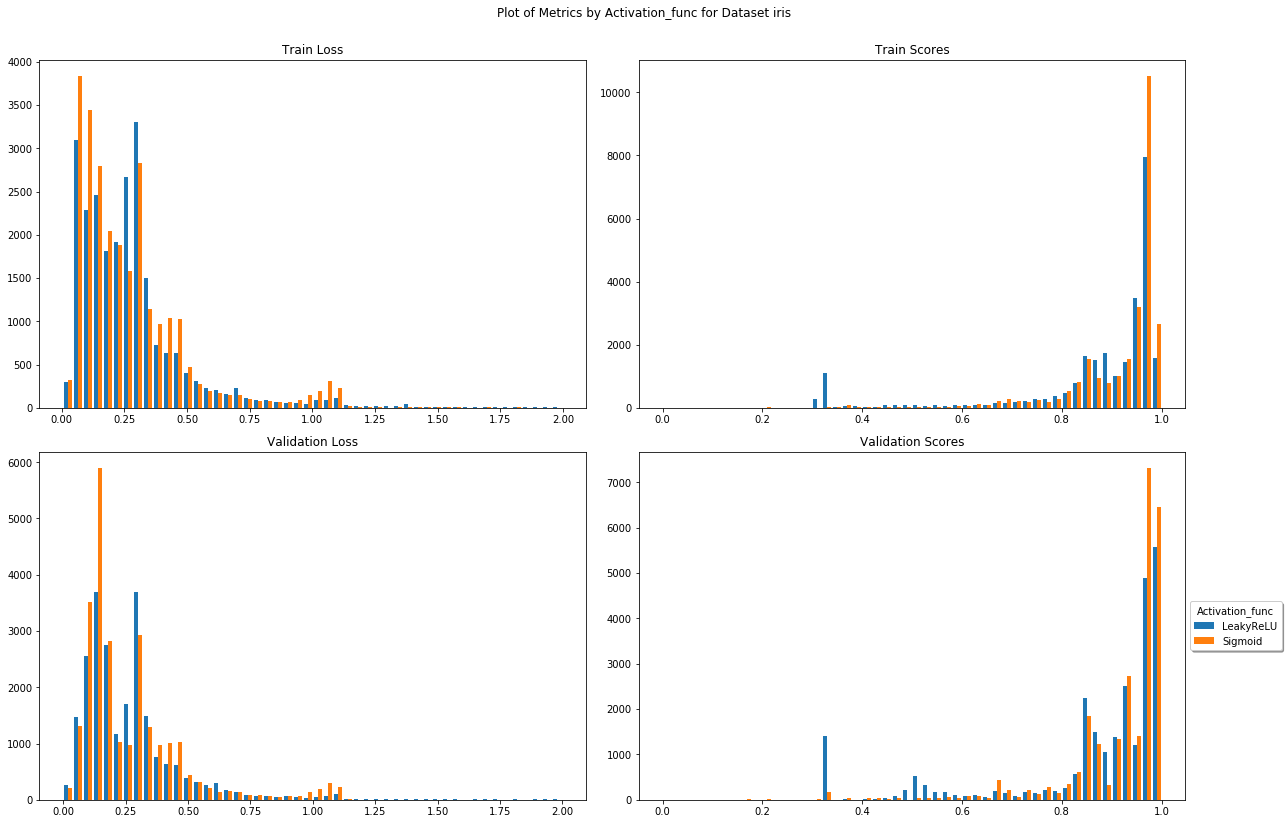

In [33]:
plot_hue(df[iris_mask(df)], hue='activation_func', thresholds=(2, -1, 2, -1))

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e4467240>,
       dtype=object))

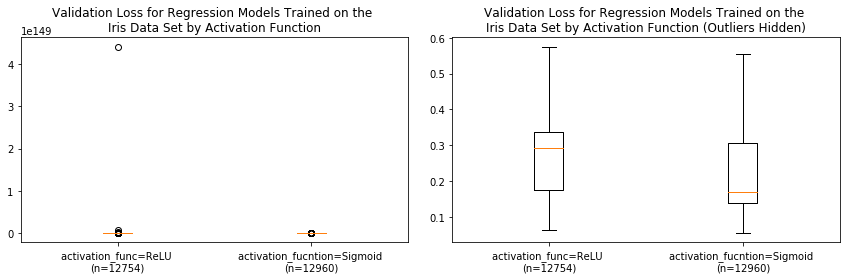

In [34]:
make_boxplot(df, iris_mask(df) & regression_mask(df), relu_mask(df), 
             'activation_func=ReLU',  'activation_fucntion=Sigmoid', 'val_loss', 
             'Validation Loss for Regression Models Trained on the \nIris Data Set by Activation Function')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d34d5390>,
       dtype=object))

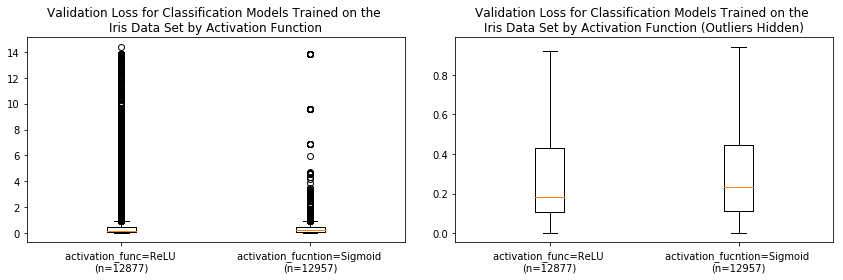

In [35]:
make_boxplot(df, iris_mask(df) & classification_mask(df), relu_mask(df), 
             'activation_func=ReLU',  'activation_fucntion=Sigmoid', 'val_loss', 
             'Validation Loss for Classification Models Trained on the \nIris Data Set by Activation Function')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e4892cf8>,
       dtype=object))

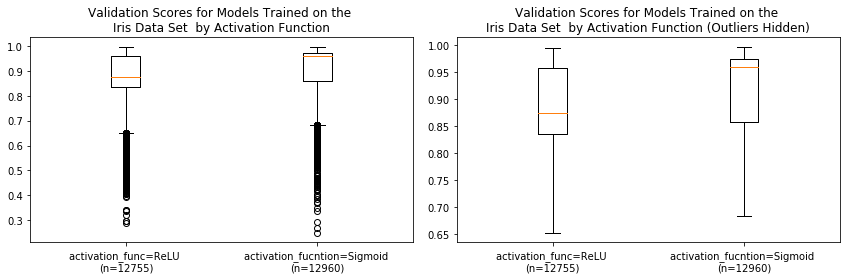

In [36]:
make_boxplot(df, iris_mask(df) & regression_mask(df), relu_mask(df), 
             'activation_func=ReLU',  'activation_fucntion=Sigmoid', 'val_scores', 
             'Validation Scores for Models Trained on the \nIris Data Set  by Activation Function')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9e47dc0b8>,
       dtype=object))

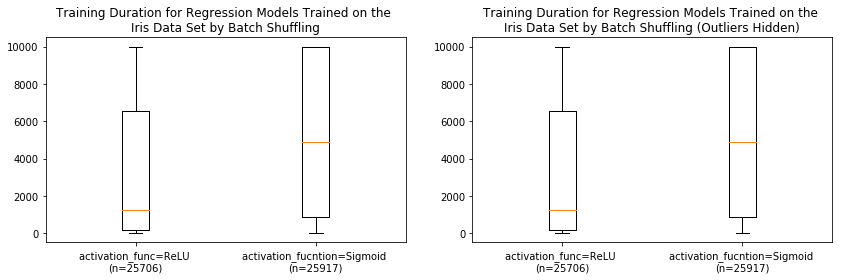

In [37]:
make_boxplot(df, iris_mask(df), relu_mask(df), 
             'activation_func=ReLU',  'activation_fucntion=Sigmoid', 'n_epochs', 
             'Training Duration for Regression Models Trained on the \nIris Data Set by Batch Shuffling')

## Learning Rate

In [38]:
def get_lr_masks_labels():
    learning_rates = list(sorted(df['learning_rate'].unique()))
    
    masks = (df['learning_rate'] == lr for lr in learning_rates)
    labels = ('learning_rate=%0.3f' % lr for lr in learning_rates)
    
    return masks, labels

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2b31208>,
       dtype=object))

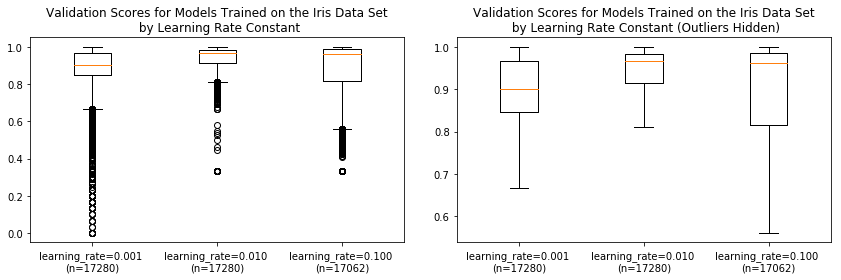

In [39]:
make_n_way_boxplot(df, iris_mask(df), 
                   *get_lr_masks_labels(),
                   'val_scores', 
                   'Validation Scores for Models Trained on the Iris Data Set\n by Learning Rate Constant')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d29f3eb8>,
       dtype=object))

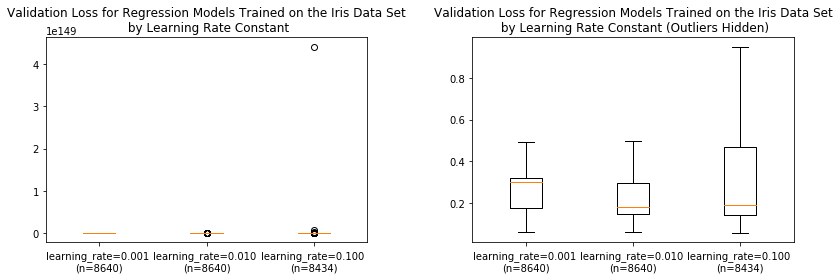

In [40]:
make_n_way_boxplot(df, iris_mask(df) & regression_mask(df), 
                   *get_lr_masks_labels(),
                   'val_loss', 
                   'Validation Loss for Regression Models Trained on the Iris Data Set\n by Learning Rate Constant')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2963da0>,
       dtype=object))

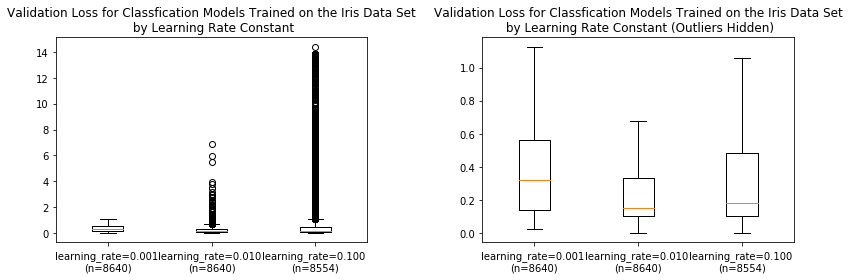

In [41]:
make_n_way_boxplot(df, iris_mask(df) & classification_mask(df), 
                   *get_lr_masks_labels(),
                   'val_loss', 
                   'Validation Loss for Classfication Models Trained on the Iris Data Set\n by Learning Rate Constant')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2963470>,
       dtype=object))

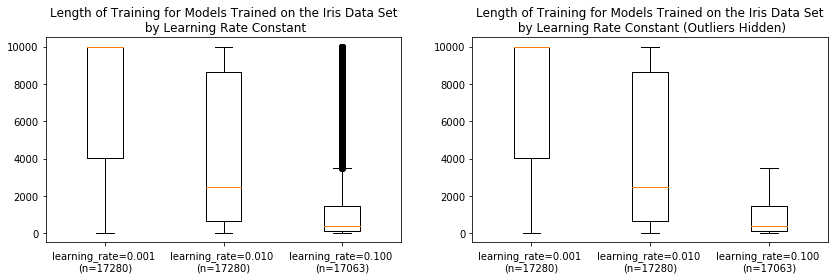

In [42]:
make_n_way_boxplot(df, iris_mask(df), 
                   *get_lr_masks_labels(),
                   'n_epochs', 
                   'Length of Training for Models Trained on the Iris Data Set\n by Learning Rate Constant')

## Momentum

In [43]:
def get_momentum_masks_labels():
    learning_rates = list(sorted(df['momentum'].unique()))
    
    masks = (df['momentum'] == lr for lr in learning_rates)
    labels = ('momentum=%0.1f' % lr for lr in learning_rates)
    
    return masks, labels

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d274e940>,
       dtype=object))

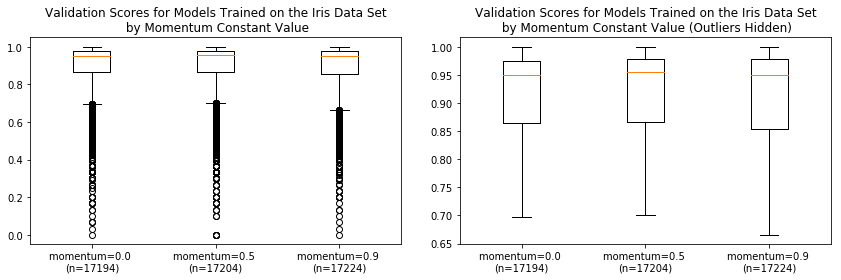

In [44]:
make_n_way_boxplot(df, iris_mask(df), 
                   *get_momentum_masks_labels(),
                   'val_scores', 
                   'Validation Scores for Models Trained on the Iris Data Set\n by Momentum Constant Value')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2648550>,
       dtype=object))

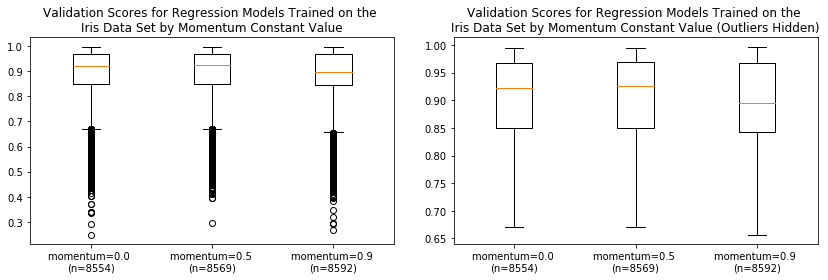

In [45]:
make_n_way_boxplot(df, iris_mask(df) & regression_mask(df), 
                   *get_momentum_masks_labels(),
                   'val_scores', 
                   'Validation Scores for Regression Models Trained on the \n'
                   'Iris Data Set by Momentum Constant Value')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d2543908>,
       dtype=object))

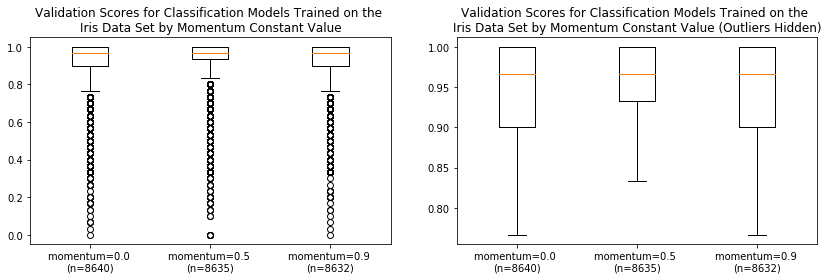

In [46]:
make_n_way_boxplot(df, iris_mask(df) & classification_mask(df), 
                   *get_momentum_masks_labels(),
                   'val_scores', 
                   'Validation Scores for Classification Models Trained on the \n'
                   'Iris Data Set by Momentum Constant Value')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d242f780>,
       dtype=object))

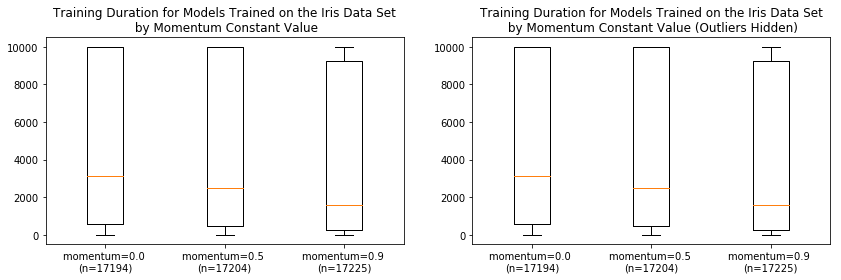

In [47]:
make_n_way_boxplot(df, iris_mask(df), 
                   *get_momentum_masks_labels(),
                   'n_epochs', 
                   'Training Duration for Models Trained on the Iris Data Set\n by Momentum Constant Value')

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd9d23a4710>,
       dtype=object))

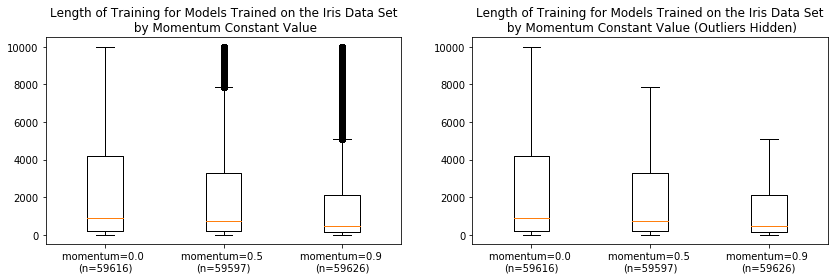

In [48]:
make_n_way_boxplot(df, True, 
                   *get_momentum_masks_labels(),
                   'n_epochs', 
                   'Length of Training for Models Trained on the Iris Data Set\n by Momentum Constant Value')